# **The Battle of Neighborhoods: Opening a Restaurant in a New City** 
#### **Segmenting neighborhoods in Toronto to find the most conducive locations for starting a restaurant using Data Science.**
by: [Usman Khan](https://www.linkedin.com/in/usman-khan-458755163/)

## **Introduction**

### **I. Background | Business Problem**

<img src="logo.png">

***Mirch Masala*** (fictitious) is a restaurant renowned for bringing the mouth-watering taste of Pakistani and Indian cuisine to your tables. Among the wide range of courses on the menu, their specialty lies in *Biryani*, *Karahi*, and *Chicken Tikka*.

Their first outing in New York City was an enormous hit. New York City is recognized as an epitome of cultural diversity, due to the immensely large population of immigrants from all over the globe. This allows it to be one of the topmost cities among other metropolitan and cosmopolitan hubs. Another city, of similar characteristics and stature, lies across the border — the City of Toronto, Canada. Home to a dense population of **6.2 million**, Toronto is Canada’s largest city and shares similar multicultural traits as New York City. And so, **the restaurant has set its eyes on expanding its business across the border in the city of Toronto.**

Our project’s objective is to figure out conducive locations in the city that are ideal for opening a restaurant. To ensure the success of our project, **the team requires insight into the demographics and the neighboring businesses**. For instance:

* The number of restaurants present in each neighborhood,
* The most popular restaurants (both similar and different cuisines),
* The traffic of our targeted demographic,
* And the frequency of our targeted audience.

This project gives **Data Scientists/Analysts** the opportunity to apply their knowledge of data science and categorically go through different processes. Defining the business problem, requirement elicitation, retrieving and utilizing data from external sources, parsing and cleaning the data, and analytical assessment through Machine Learning algorithms and tools. The evaluation from the final analysis leads to a conclusion which can then be leveraged by stakeholders. As this project has a lot of aspects to be considered, **it is open for discussion** and targeted towards the **entrepreneurs** and **stakeholders**.

### **II. Description of Data**

The data required will be a combination of CSV files that have been prepared for the purpose of the analysis.

* 1st set of Data:
Recent most updated record of traffic signal — vehicle and pedestrian volumes in Toronto. This data is typically collected between 7:30 a.m. and 6:00 p.m. at intersections where there are traffic signals.

* 2nd set of Data: 
The list of neighborhoods in Toronto represented by postal codes and their boroughs. We will be using the **Geocoder** Python package to retrieve the postal code’s coordinates.

* 3rd set of Data: 
The most common venues of a given neighborhood in Toronto. This information is stored inside **Foursquare Location Data**, and we will use **Foursquare API** in order to access it.

To recap, we will use the 1st set of Data to analyze the pedestrian/vehicle volume. Then, we load the 2nd set of Data to obtain the exact coordinates for each neighborhood based on their respective postal code, allowing us to explore and map the city. By using those coordinates and Foursquare credentials, we will access the 3rd set of Data sources through Foursquare API, and retrieve the popular venues along with their details, especially for restaurants (irrespective of their cuisine).

## **Methodology**

### **I. Data Acquisition & Cleaning**

In [77]:
!pip install lxml

In [78]:
# import necessary libraries 
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

%matplotlib inline

In [79]:
# Get the neighborhood data using beautiful soup 
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urlopen(url).read().decode('utf-8')
soup = BeautifulSoup(page, 'html.parser')

wiki_table = soup.body.table.tbody

In [80]:
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [81]:
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row

def get_row():    
    data = []  
    
    for tr in wiki_table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

In [82]:
data = get_row()
columns = ['PostalCode', 'Borough', 'Neighborhood']
df = pd.DataFrame(data, columns=columns)
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [83]:
df_grouped = df.groupby(['PostalCode', 'Borough'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn


In [84]:
df1 = df[df.Borough != 'Not assigned']
df1 = df1.sort_values(by=['PostalCode','Borough'])

df1.reset_index(inplace=True)
df1.drop('index',axis=1,inplace=True)

In [85]:
df1.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [86]:
df_postcodes = df1['PostalCode']
df_postcodes.drop_duplicates(inplace=True)
df2 = pd.DataFrame(df_postcodes)
df2['Borough'] = '';
df2['Neighborhood'] = '';


df2.reset_index(inplace=True)
df2.drop('index', axis=1, inplace=True)
df1.reset_index(inplace=True)
df1.drop('index', axis=1, inplace=True)

for i in df2.index:
    for j in df1.index:
        if df2.iloc[i, 0] == df1.iloc[j, 0]:
            df2.iloc[i, 1] = df1.iloc[j, 1]
            df2.iloc[i, 2] = df2.iloc[i, 2] + ',' + df1.iloc[j, 2]
            
for i in df2.index:
    s = df2.iloc[i, 2]
    if s[0] == ',':
        s =s [1:]
    df2.iloc[i,2 ] = s

In [87]:
df2.shape

(103, 3)

In [88]:
geospatial_url = "https://cocl.us/Geospatial_data"
df_geo = pd.read_csv(geospatial_url)

df2['Latitude'] = '0';
df2['Longitude'] = '0';

df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [89]:
for i in df2.index:
    for j in df_geo.index:
        if df2.iloc[i, 0] == df_geo.iloc[j, 0]:
            df2.iloc[i, 3] = df_geo.iloc[j, 1]
            df2.iloc[i, 4] = df_geo.iloc[j, 2]
            
df2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.8067,-79.1944
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.7845,-79.1605
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7636,-79.1887
3,M1G,Scarborough,Woburn,43.771,-79.2169
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395


In [90]:
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Not assigned        77
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [91]:
boroughs = df2['Borough'].unique().tolist()

In [92]:
from geopy.geocoders import Nominatim

address = 'Toronto, Ontario'

# Define a unique user_agent
geolocator = Nominatim(user_agent="toronto_explorer")

# Retrieve Toronto coordinate
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [93]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# create map of Toronto using latitude and longitude values
ft_map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, mainroad, pedes, vehic in zip(ft_main_top['Latitude'], ft_main_top['Longitude'], ft_main_top['Main'], ft_main_top['8 Peak Hr Pedestrian Volume'], ft_main_top['8 Peak Hr Vehicle Volume']):
    label = '{}, (Pedestrian Volume Avg: {}, Vehicle Volume Avg: {})'.format(mainroad, round(pedes, 2), round(vehic, 2))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(ft_map_toronto)  
    
ft_map_toronto

In [94]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [95]:
toronto_venues = getNearbyVenues(names=df2['Neighborhood'],
                                latitudes=df2['Latitude'],
                                longitudes=df2['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [96]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [97]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,55,55,55,55,55,55
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",25,25,25,25,25,25
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16


In [98]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 277 uniques categories.


In [99]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Fast Food Restaurant' 'Bar' 'Construction & Landscaping' 'Bank'
 'Electronics Store' 'Restaurant' 'Mexican Restaurant'
 'Rental Car Location' 'Medical Center' 'Intersection' 'Breakfast Spot'
 'Coffee Shop' 'Korean BBQ Restaurant' 'Hakka Restaurant'
 'Caribbean Restaurant' 'Thai Restaurant' 'Athletics & Sports'
 'Gas Station' 'Bakery' 'Fried Chicken Joint' 'Playground' 'Jewelry Store'
 'Smoke Shop' 'Department Store' 'Hobby Shop' 'Train Station'
 'Ice Cream Shop' 'Bus Line' 'Metro Station' 'Bus Station' 'Park'
 'Soccer Field' 'Motel' 'American Restaurant' 'Café'
 'General Entertainment' 'Skating Rink' 'College Stadium'
 'Chinese Restaurant' 'Indian Restaurant' 'Vietnamese Restaurant'
 'Pet Store' 'Sandwich Place' 'Middle Eastern Restaurant' 'Auto Garage'
 'Accessories Store' 'Latin American Restaurant' 'Lounge' 'Clothing Store'
 'Italian Restaurant' 'Noodle House' 'Pizza Place' 'Pharmacy'
 'Grocery Store' 'Gym' 'Golf Course' 'Pool' 'Mediterranean Restaurant'
 

In [100]:
"Indian Restaurant" in toronto_venues['Venue Category'].unique()

True

### **II. Analytic Approach**

#### **One-Hot Encoding**

We begin our pursuit by approaching the problem using a technique called **one-hot encoding**. This technique can transform data from categorical form to numerical form for Machine Learning algorithms. Each and every venue was turned into a *frequency* at how many of those venues were in each candidate neighborhood.

In [101]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2167, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Road,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rou

Then, we grouped those rows by ***Neighborhood*** and by taking the **average** frequency of occurrence for each venue category.

In [102]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(96, 278)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Road,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0

In [103]:
ita = to_grouped[["Neighborhoods","Indian Restaurant"]]
ita.head() #.head() shows the first five rows only
ta = ita.rename(columns={'Neighborhoods':'Neighborhood'})
ta.head()

,Neighborhood,Indian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.045455


#### **K-Means Clustering**

In order to see how the demographics exist for similar neighborhoods, and to make the analysis visually interesting, we use a clustering technique called ***k-means***. ***k-means*** is a common machine learning algorithm used to cluster data points based on similar characteristics. The algorithm is fast and efficient for a medium and large-sized database and is useful to quickly discover insights from unlabeled data. By observing and examining each and every cluster, we can then determine those categories that distinguish them from one another.

### **III. Data Analysis**

#### **Vehicle and Foot Traffic**

We begin by analyzing the data about the pedestrian and vehicle volumes. The first time you open it, you will soon realize that the column ***Main*** is indicating the *main street name*, and the same name appears several time indicating it contains intersections.

In [104]:
ft_df=pd.read_excel('traffic-signal-vehicle-and-pedestrian-volumes-data.xlsx')
print(ft_df.shape)
ft_df.head()

(2280, 11)


,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,2017-06-21,15662,13535
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,2016-09-17,12960,7333
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,2016-11-08,17770,7083
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,2015-12-08,19678,4369
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,2016-09-17,14487,3368


In [105]:
ft_df.tail()

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
2275,3005,WINDERMERE AVE,NaN,MORNINGSIDE AVE,NaN,01/01/1967,43.644885,-79.478592,2009-12-10,6488,634
2276,3006,GATEWAY BLVD,NaN,GRENOBLE DR,NaN,05/28/1976,43.711967,-79.330476,2017-05-02,7447,1316
2277,3009,ALLIANCE AVE,NaN,ROCKCLIFFE BLVD,NaN,02/13/1969,43.676947,-79.489360,2018-02-15,8780,498
2278,3011,OLD FINCH AVE,250m EAST OF,SEWELLS RD,NaN,04/11/1974,43.825259,-79.196812,2008-11-27,1081,0
2279,3014,ZOO RD,NaN,MEADOWVALE RD N ZOO W RAMP,ZOO MEADOWVALE RD N RAMP,02/08/1974,43.818187,-79.173580,2009-07-26,1982,16


We can aggregate this by either summing those value up, or by simply averaging it. For the sake of simplicity, we will choose to average it. This returns ***248 main roads***.

In [106]:
ft_main = ft_df.groupby(by='Main')[['8 Peak Hr Pedestrian Volume','8 Peak Hr Vehicle Volume', 'Latitude', 'Longitude']].mean().sort_values(by='8 Peak Hr Pedestrian Volume', ascending=False).reset_index()
ft_main

,Main,8 Peak Hr Pedestrian Volume,8 Peak Hr Vehicle Volume,Latitude,Longitude
0,BLOOR ST,23335.000000,14398.000000,43.670229,-79.386767
1,BAY ST,17194.750000,14524.450000,43.658325,-79.384589
2,YORK ST,16209.750000,11101.250000,43.647326,-79.383293
3,FRONT ST W,16060.500000,10568.750000,43.643394,-79.390946
4,UNIVERSITY AVE,12846.090909,22119.545455,43.651889,-79.386793
5,CHERRY ST,12802.000000,15814.000000,43.645257,-79.352682
6,SIMCOE ST,12058.000000,8156.500000,43.647364,-79.386061
7,ST GEORGE ST,11189.000000,6902.333333,43.661970,-79.397540
8,VICTORIA ST,10589.000000,11767.000000,43.651952,-79.377756
9,WELLINGTON ST W,10022.500000,8401.000000,43.645012,-79.390478


In [107]:
ft_main.describe()

,8 Peak Hr Pedestrian Volume,8 Peak Hr Vehicle Volume,Latitude,Longitude
count,248.000000,248.000000,248.000000,248.000000
mean,1855.100736,11274.239194,43.710040,-79.395862
std,3190.819880,5193.129205,0.056145,0.102267
min,0.000000,1081.000000,43.603757,-79.622225
25%,343.500000,7403.750000,43.660016,-79.472370
50%,675.000000,10466.433824,43.703423,-79.390913
75%,1653.678571,13938.031250,43.761615,-79.330196
max,23335.000000,29797.428571,43.825259,-79.140419


In [108]:
ft_main_top = ft_main[(ft_main['8 Peak Hr Pedestrian Volume']>1200) | (ft_main['8 Peak Hr Vehicle Volume']>12000)].reset_index()
ft_main_top.drop(columns='index', inplace=True)
print(ft_main_top.shape)
ft_main_top.head()

(139, 5)


,Main,8 Peak Hr Pedestrian Volume,8 Peak Hr Vehicle Volume,Latitude,Longitude
0,BLOOR ST,23335.000000,14398.000000,43.670229,-79.386767
1,BAY ST,17194.750000,14524.450000,43.658325,-79.384589
2,YORK ST,16209.750000,11101.250000,43.647326,-79.383293
3,FRONT ST W,16060.500000,10568.750000,43.643394,-79.390946
4,UNIVERSITY AVE,12846.090909,22119.545455,43.651889,-79.386793


We want to make sure that the taregeted neighborhoods are active. Hence, we will filter out the main roads. In this example, we only show the roads with the average of **pedestrian volume *above 1200*** or **vehicle volume *above 12000*** during peak hour **(above ~70%)**. This gives us **139 main roads**. Finally, we can visualize the roads using the **Folium Python** module from the given coordinates. The map shows a glimpse of the busiest roads in the city, where many are located around downtown.

In [109]:
!pip install geopy

In [110]:
from geopy.geocoders import Nominatim

address = 'Toronto, Ontario'

# Define a unique user_agent
geolocator = Nominatim(user_agent="toronto_explorer")

# Retrieve Toronto coordinate
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [111]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# create map of Toronto using latitude and longitude values
ft_map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, mainroad, pedes, vehic in zip(ft_main_top['Latitude'], ft_main_top['Longitude'], ft_main_top['Main'], ft_main_top['8 Peak Hr Pedestrian Volume'], ft_main_top['8 Peak Hr Vehicle Volume']):
    label = '{}, (Pedestrian Volume Avg: {}, Vehicle Volume Avg: {})'.format(mainroad, round(pedes, 2), round(vehic, 2))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(ft_map_toronto)  
    
ft_map_toronto

In [112]:
CLIENT_ID = 'C021C4VZT5LZSXDTLIRZ134LBHMBRAEDKYYP1MN1NEZUM2KJ' # your Foursquare ID
CLIENT_SECRET = 'PUUJYQWG0QSASKYJIBCFLUUHDXYBGB41RUG5OLL1NXP1HF2D' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')

Credentials Stored


In the next section, we will explore the neighborhoods inside Central Toronto, East York, and York as the selected boroughs.

#### **Neighborhoods Analysis**

We have built a neighborhood data frame that comprises **103 postal codes**, **10 boroughs** with **neighborhood names** inside each borough, and **their coordinates**. We even used our One-Hot encoding technique to obtain the frequency of occurrences of the venues located in each neighborhood. Since we are specifically interested in neighborhoods inside **Central Toronto**, **East York**, and **York** only, we proceed by filtering the data frame resulting in **3 boroughs** and **19 neighborhoods**.

As we have the coordinates information, we can then head over to Foursquare API and use it to access the data, analyze and explore the neighborhoods, and get the **top 100 venues** within a **radius of 1 km** for each. It returns a filtered result, with **905 venues** with **172 unique venue categories**.

In [113]:
boroughs_df= pd.read_csv('boroughs_venues.csv')
boroughs_df

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkview Hill,43.70718,-79.31192,Toronto Climbing Academy,43.709362,-79.315006,Rock Climbing Spot
1,Parkview Hill,43.70718,-79.31192,Jawny Bakers,43.705783,-79.312913,Gastropub
2,Parkview Hill,43.70718,-79.31192,Muddy York Brewing Co.,43.712362,-79.312019,Brewery
3,Parkview Hill,43.70718,-79.31192,East York Gymnastics,43.710654,-79.309279,Gym / Fitness Center
4,Parkview Hill,43.70718,-79.31192,Peek Freans Cookie Outlet,43.713260,-79.308063,Bakery
5,Parkview Hill,43.70718,-79.31192,Shoppers Drug Mart,43.705933,-79.312825,Pharmacy
6,Parkview Hill,43.70718,-79.31192,TD Canada Trust,43.705740,-79.312270,Bank
7,Parkview Hill,43.70718,-79.31192,Pizza Pizza,43.705159,-79.313130,Pizza Place
8,Parkview Hill,43.70718,-79.31192,Harvey's,43.710964,-79.309085,Fast Food Restaurant
9,Parkview Hill,43.70718,-79.31192,Tim Hortons,43.714401,-79.307356,Coffee Shop


In [114]:
neighbor_df = boroughs_df.groupby(by='Neighborhood').count().sort_values(by='Venue', ascending=False).reset_index()

In [115]:
neighbor_df 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Davisville,100,100,100,100,100,100
1,Davisville North,100,100,100,100,100,100
2,The Annex,100,100,100,100,100,100
3,Summerhill West,89,89,89,89,89,89
4,Woodbine Heights,68,68,68,68,68,68
5,Moore Park,66,66,66,66,66,66
6,Leaside,61,61,61,61,61,61
7,East Toronto,60,60,60,60,60,60
8,North Toronto West,49,49,49,49,49,49
9,Thorncliffe Park,38,38,38,38,38,38


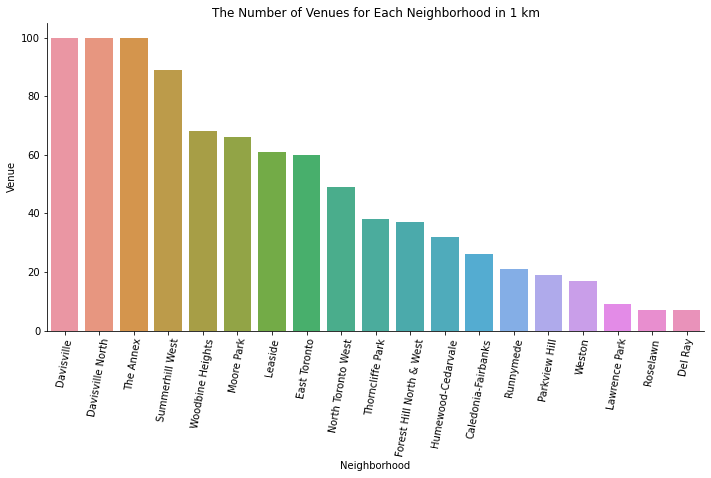

In [116]:
g = sns.catplot( data=neighbor_df, x='Neighborhood', y='Venue', kind='bar', aspect=2)
g.set_xticklabels(rotation=80)
g.set(title='The Number of Venues for Each Neighborhood in 1 km')

Many neighborhoods returned **above** 50 venues, such as *Davisville* and *Davisville North* with 100 venues each. However, many returned **below** 50 venues, such as *Thorncliffe Park* with 38 venues, and *Parkview Hill* with 19 venues. For each neighborhood, we can create the top 10 venues based on occurrences as follows.

In [117]:
# one hot encoding and adjust the name prefix
boroughs_onehot = pd.get_dummies(boroughs_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to the dataframe
boroughs_onehot['Neighbourhood'] = boroughs_df['Neighborhood']

# # move neighborhood column to the first column
fixed_columns = [boroughs_onehot.columns[-1]] + list(boroughs_onehot.columns[:-1])
boroughs_onehot = boroughs_onehot[fixed_columns]
boroughs_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Neighborhood,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Social Club,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkview Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkview Hill,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [118]:
print(boroughs_onehot.shape)

(906, 173)


In [119]:
boroughs_grouped = boroughs_onehot.groupby(by='Neighbourhood').mean().reset_index()
boroughs_grouped

,Neighbourhood,Afghan Restaurant,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Bike Shop,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Chinese Restaurant,Chiropractor,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Neighborhood,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Social Club,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Caledonia-Fairbanks,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.038462,0.00,0.000000,0.038462,0.038462,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.076923,0.000000,0.000000,0.000000,0.038462,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.038462,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.038462,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.038462,0.000000,0.00,0.000000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.038462,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.038462,0.192308,0.000000,0.000000,0.038462,0.000000,0.00,0.000000,0.038462,0.000000,0.000000,0.00,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.038462,0.000000
1,Davisville,0.000000,0.000000,0.000000,0.02,0.000000,0.000000,0.000000,0.01,0.010000,0.030000,0.020000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [120]:
len(boroughs_onehot.Neighbourhood.unique())

19

In [121]:
boroughs_grouped.shape

(19, 173)

In [122]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        # Add column names such as 1st, 2nd, 3rd Most Common Venue
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # Add column names such as 4th, 5th, .. ,10th Most Common Venue
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# In the end, we have:
# columns == ['Neighborhood', '1st Most Common Venue', .. , '10th Most Common Venue']        

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boroughs_grouped['Neighbourhood']

for ind in np.arange(boroughs_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boroughs_grouped.iloc[ind, :], num_top_venues)

In [123]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Caledonia-Fairbanks,Pizza Place,Park,Coffee Shop,Portuguese Restaurant,Bus Line,Grocery Store,Women's Store,Japanese Restaurant,Food Truck,Mexican Restaurant
1,Davisville,Italian Restaurant,Coffee Shop,Sushi Restaurant,Indian Restaurant,Café,Restaurant,Pizza Place,Dessert Shop,Gym,Bakery
2,Davisville North,Coffee Shop,Italian Restaurant,Café,Pizza Place,Dessert Shop,Restaurant,Gym,Fast Food Restaurant,Park,Japanese Restaurant
3,Del Ray,Park,Convenience Store,Grocery Store,Coffee Shop,Sandwich Place,Fast Food Restaurant,Gas Station,Discount Store,Falafel Restaurant,Ethiopian Restaurant
4,East Toronto,Coffee Shop,Café,Sandwich Place,Ethiopian Restaurant,Pizza Place,Convenience Store,Park,Thai Restaurant,Beer Store,Beer Bar


The data frame above is an indication that we have the same venue categories returned to different neighborhoods. We can use this idea to **cluster the neighborhoods based on their venues** representing services and amenities.

#### **Clustering the Neighborhoods**

In [124]:
ita = to_grouped[["Neighborhoods","Indian Restaurant"]]
ita.head() #.head() shows the first five rows only

,Neighborhoods,Indian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.045455


In [125]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

In [126]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = ita.drop(['Neighborhood'], axis=1)

In [127]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [128]:
scores = [get_inertia(x) for x in range(2, 21)]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab

Text(0, 0.5, 'Error')

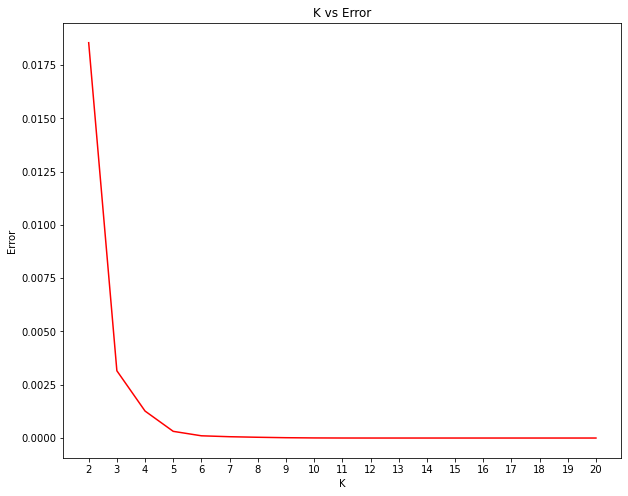

In [129]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [130]:
!pip install -U scikit-learn scipy matplotlib

Requirement already up-to-date: scikit-learn in /home/jupyterlab/conda/lib/python3.8/site-packages (0.23.2)
Requirement already up-to-date: scipy in /home/jupyterlab/conda/lib/python3.8/site-packages (1.5.4)
Requirement already up-to-date: matplotlib in /home/jupyterlab/conda/lib/python3.8/site-packages (3.3.3)


In [131]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

NameError: name 'KElbowVisualizer' is not defined

In [ ]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [ ]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [ ]:
to_merged.head()